## Python Imports

In [2]:
import math
from re import sub
import warnings

import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.manifold import MDS
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn import set_config

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from kmodes.kprototypes import KPrototypes
from hdbscan import HDBSCAN

from tqdm import tqdm
from gower import gower_matrix
from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram

from matplotlib import pyplot as plt

## R Imports

In [15]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.ipython.ggplot import image_png

base = importr('base')
utils = importr('utils')
stats = importr('stats')
facto_miner = importr('FactoMineR')
facto_extra = importr('factoextra')

## Global

In [3]:
seed = 12
rs = np.random.RandomState(seed)

fig_size = (15, 13)

set_config(transform_output='pandas')

warnings.filterwarnings('ignore')

## Helpers

In [413]:
def plot_dendrogram(model, **kwargs):
    """
    Create linkage matrix and then plot the dendrogram. This function is taken from the sklearn documentation.
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    """

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        
        current_count = 0
        
        for child_idx in merge:

            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                # Node i >= n_samples is a non-leaf node, and the value of counts[i - n_samples] is the number of samples contained in the subtree rooted at node i
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Data

<center>

| Variable | Description | Categories |
| --- | --- | --- |
| Year | Year of data collection | 2008 |
| Month | Month of data collection | 4 (April) - 8 (August) |
| Day | Day of the month | 1-31 |
| Order | Sequence of clicks during one session | N/A |
| Country | Country of origin of the IP address | 1-Australia<br>2-Austria<br>3-Belgium<br>4-British Virgin Islands<br>5-Cayman Islands<br>6-Christmas Island<br>7-Croatia<br>8-Cyprus<br>9-Czech Republic<br>10-Denmark<br>11-Estonia<br>12-Unidentified<br>13-Faroe Islands<br>14-Finland<br>15-France<br>16-Germany<br>17-Greece<br>18-Hungary<br>19-Iceland<br>20-India<br>21-Ireland<br>22-Italy<br>23-Latvia<br>24-Lithuania<br>25-Luxembourg<br>26-Mexico<br>27-Netherlands<br>28-Norway<br>29-Poland<br>30-Portugal<br>31-Romania<br>32-Russia<br>33-San Marino<br>34-Slovakia<br>35-Slovenia<br>36-Spain<br>37-Sweden<br>38-Switzerland<br>39-Ukraine<br>40-United Arab Emirates<br>41-United Kingdom<br>42-USA<br>43-biz (*.biz)<br>44-com (*.com)<br>45-int (*.int)<br>46-net (*.net)<br>47-org (*.org) |
| Session ID | ID of the session | N/A |
| Page 1 (Main Category) | Main product category | 1-Trousers<br>2-Skirts<br>3-Blouses<br>4-Sale |
| Page 2 (Clothing Model) | Code for each product | 217 products |
| Colour | Colour of product | 1-Beige<br>2-Black<br>3-Blue<br>4-Brown<br>5-Burgundy<br>6-Gray<br>7-Green<br>8-Navy Blue<br>9-Of many colors<br>10-Olive<br>11-Pink<br>12-Red<br>13-Violet<br>14-White |
| Location | Photo location on the page | 1-Top left<br>2-Top in the middle<br>3-Top right<br>4-Bottom left<br>5-Bottom in the middle<br>6-Bottom right |
| Model Photography | Type of model photography | 1-En face<br>2-Profile |
| Price | Price in US dollars | N/A |
| Price 2 | Whether the price is higher than the average | 1-Yes<br>2-No |
| Page | Page number within the e-store website | 1-5 |

</center>

In [4]:
df = pd.read_parquet('../../data/classification/e_shopping_data.parquet', engine='pyarrow')
df.shape

(165474, 14)

In [5]:
df.dtypes

year                        int64
month                       int64
day                         int64
order_clicks                int64
country                     int64
session_id                  int64
page_main_prod_category     int64
page_product_code          object
prod_color                  int64
photo_location              int64
model_photo                 int64
price                       int64
price_higher_avg            int64
page_number                 int64
dtype: object

In [6]:
df.head(5)

,year,month,day,order_clicks,country,session_id,page_main_prod_category,page_product_code,prod_color,photo_location,model_photo,price,price_higher_avg,page_number
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


Check for missing values:

In [7]:
df.isna().sum()

year                       0
month                      0
day                        0
order_clicks               0
country                    0
session_id                 0
page_main_prod_category    0
page_product_code          0
prod_color                 0
photo_location             0
model_photo                0
price                      0
price_higher_avg           0
page_number                0
dtype: int64

### EDA

In [8]:
num_cols = ['order_clicks', 'price']
cat_cols = ['month', 'day', 'country', 'page_main_prod_category', 'page_product_code', 'prod_color', 'photo_location', 'model_photo', 'price_higher_avg', 'page_number']

In [9]:
# Convert categorical columns to string, so that R can convert them to factors
df[cat_cols] = df[cat_cols].astype(str)

df.dtypes

year                        int64
month                      object
day                        object
order_clicks                int64
country                    object
session_id                  int64
page_main_prod_category    object
page_product_code          object
prod_color                 object
photo_location             object
model_photo                object
price                       int64
price_higher_avg           object
page_number                object
dtype: object

Continuous features:

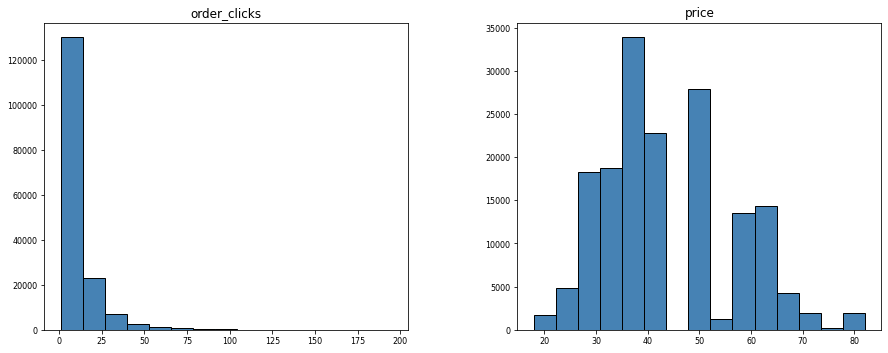

In [12]:
df[num_cols].hist(figsize=fig_size, bins=15, layout=(2, 2), color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False);

Categorical features:

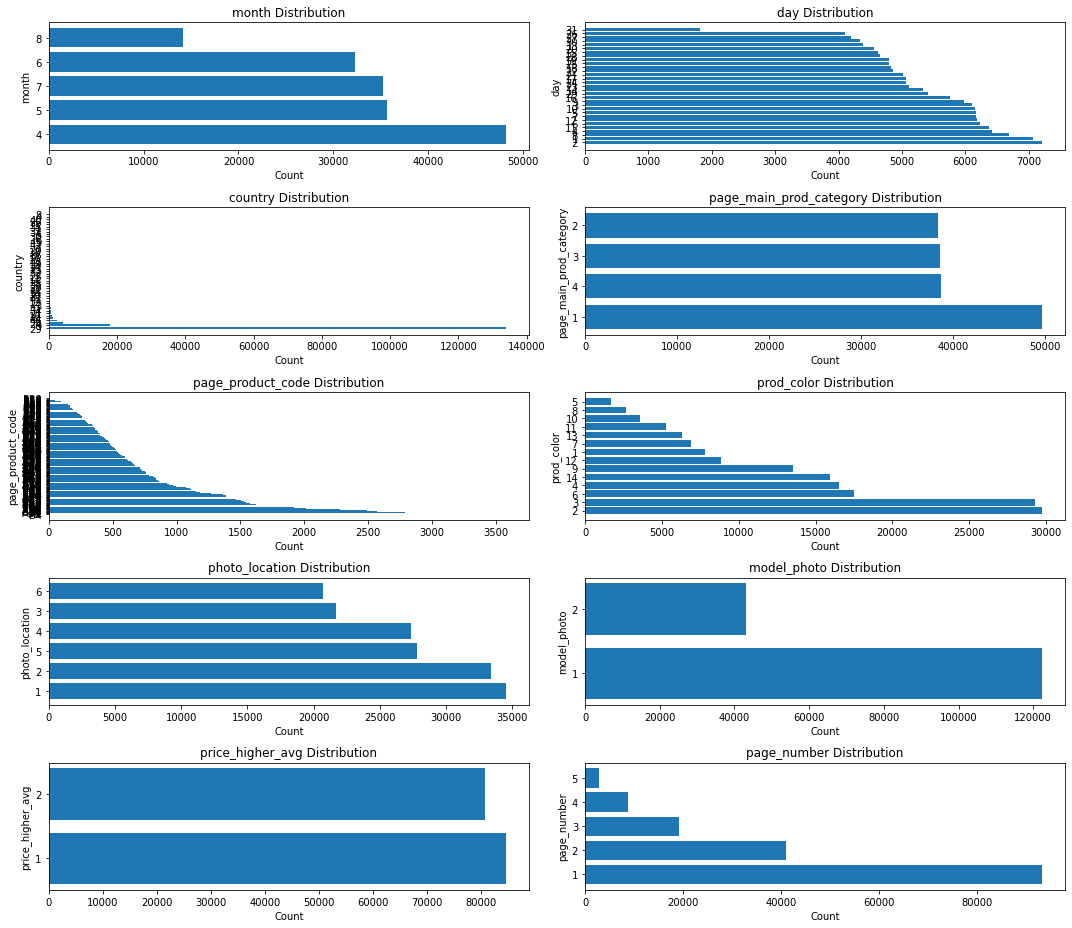

In [153]:
max_plots_per_row = 5

# Calculate the number of rows and columns in the grid layout
num_of_rows = 5
num_of_cols = math.ceil(len(df[cat_cols].columns) / max_plots_per_row)

# Set up plot panel
fig, axs = plt.subplots(nrows=num_of_rows, ncols=num_of_cols, figsize=fig_size)
axs = axs.flatten()

for i, column in enumerate(df[cat_cols].columns):
    # Count the frequency of each category
    counts = df[column].value_counts()
    # Create a horizontal bar chart for the category counts
    axs[i].barh(counts.index, counts.values)
    # Set the axis labels and title
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel(column)
    axs[i].set_title(f'{column} Distribution')
    
plt.tight_layout()
plt.show();

## Factor Analysis for Mixed Data

The FAMD is a principal component method dedicated to exploring data with both continuous and categorical variables. It can be seen roughly as a mixed between PCA and MCA (multiple correspondence analysis). More precisely, the continuous variables are scaled to unit variance and the categorical variables are transformed into a disjunctive data table (crisp coding) and then scaled using the specific scaling of MCA. This ensures a balance between the influence of both continuous and categorical variables in the analysis. It means that both types of variables are on an equal footing in terms of their influence on the dimensions of the variability of the data.

In [14]:
df_famd = df.drop(columns=['session_id', 'year'])

with (ro.default_converter + pandas2ri.converter).context():
  df_famd_r = ro.conversion.py2rpy(df_famd) # Convert pandas dataframe to R dataframe
  utils.str(df_famd_r)

'data.frame':	165474 obs. of  12 variables:
 $ month                  : chr  "4" "4" "4" "4" ...
 $ day                    : chr  "1" "1" "1" "1" ...
 $ order_clicks           : int  1 2 3 4 5 6 7 8 9 1 ...
 $ country                : chr  "29" "29" "29" "29" ...
 $ page_main_prod_category: chr  "1" "1" "2" "2" ...
 $ page_product_code      : chr  "A13" "A16" "B4" "B17" ...
 $ prod_color             : chr  "1" "1" "10" "6" ...
 $ photo_location         : chr  "5" "6" "2" "6" ...
 $ model_photo            : chr  "1" "1" "1" "2" ...
 $ price                  : int  28 33 52 38 52 57 33 38 48 57 ...
 $ price_higher_avg       : chr  "2" "2" "1" "2" ...
 $ page_number            : chr  "1" "1" "1" "1" ...


In [64]:
# Apply FAMD
famd_result = facto_miner.FAMD(df_famd_r, ncp=12, graph=False)
famd_result

eig,[RTYPES.REALSXP]
ind,[RTYPES.VECSXP]
var,[RTYPES.VECSXP]
quali.var,[RTYPES.VECSXP]
quanti.var,[RTYPES.VECSXP]
svd,[RTYPES.VECSXP]
call,[RTYPES.VECSXP]


The proportion of inertia retained by the various dimensions (axes) can be extracted as follows:

In [65]:
# Extracting using R's rx or rx2 functions a.k.a. [ or [[ 
eigen_result = np.array(famd_result.rx2('eig'))

famd_exp_var = pd.DataFrame(eigen_result, columns=['eigenvalues', 'percentage_of_inertia', 'cumulative_percentage_of_inertia'], index=[f'comp_{i}' for i in range(1, 13)])
famd_exp_var

,eigenvalues,percentage_of_inertia,cumulative_percentage_of_inertia
comp_1,3.504354,1.078263,1.078263
comp_2,2.988740,0.919612,1.997875
comp_3,2.636105,0.811109,2.808984
comp_4,2.508478,0.771839,3.580824
comp_5,2.480736,0.763304,4.344127
comp_6,2.369152,0.728970,5.073097
comp_7,2.336624,0.718961,5.792058
comp_8,2.289243,0.704382,6.496441
comp_9,2.237880,0.688578,7.185019
comp_10,2.192080,0.674486,7.859506


We can plot the scree plot as follow:

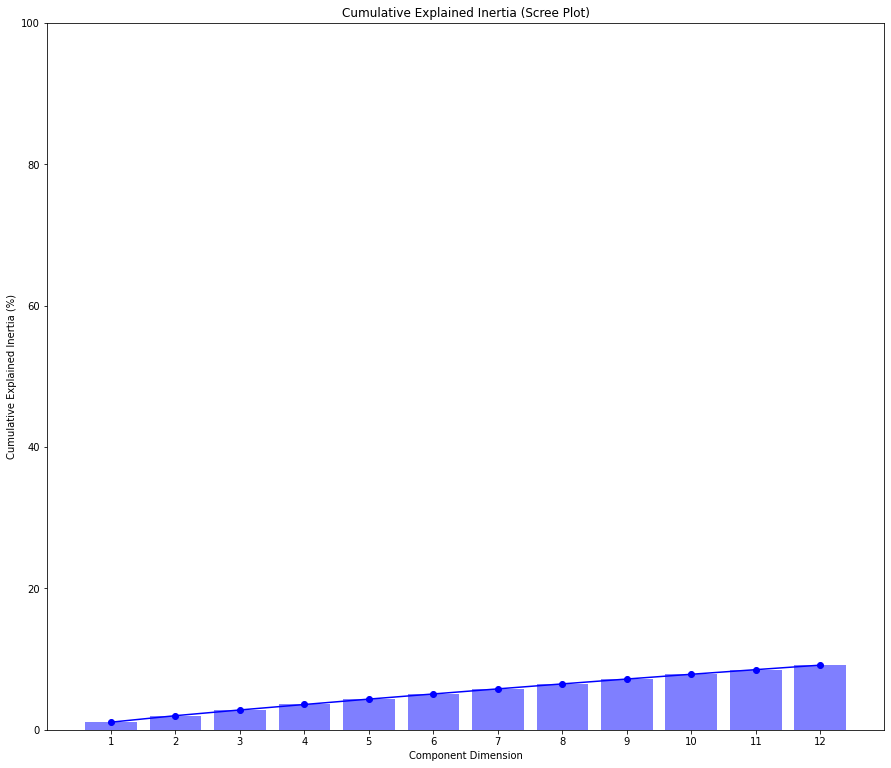

In [66]:
# Cumulative explained variance
cum_exp_var = famd_exp_var['cumulative_percentage_of_inertia'].values
comp_indices = range(1, 12 + 1)

fig, ax = plt.subplots(figsize=fig_size)
ax.plot(comp_indices, cum_exp_var, color='blue')
ax.bar(comp_indices, cum_exp_var, color='blue', alpha=0.5)
ax.scatter(comp_indices, cum_exp_var, color='blue')
plt.title('Cumulative Explained Inertia (Scree Plot)')
plt.ylim(0, 100)
plt.xticks(comp_indices)
plt.xlabel('Component Dimension')
plt.ylabel('Cumulative Explained Inertia (%)')
plt.show();

As can be seen, FAMD may not be a useful dimensionality reduction technique here due to the fact that cumulative explained inertia is too low for dimensions $< 12$. This is due to the fact that the categorical features are one-hot encoded and so even if we use the original number of dimension (i.e., 12), the explained inertia will not be 100 percent. Nevertheless, we can visualize the output of FAMD as follows:

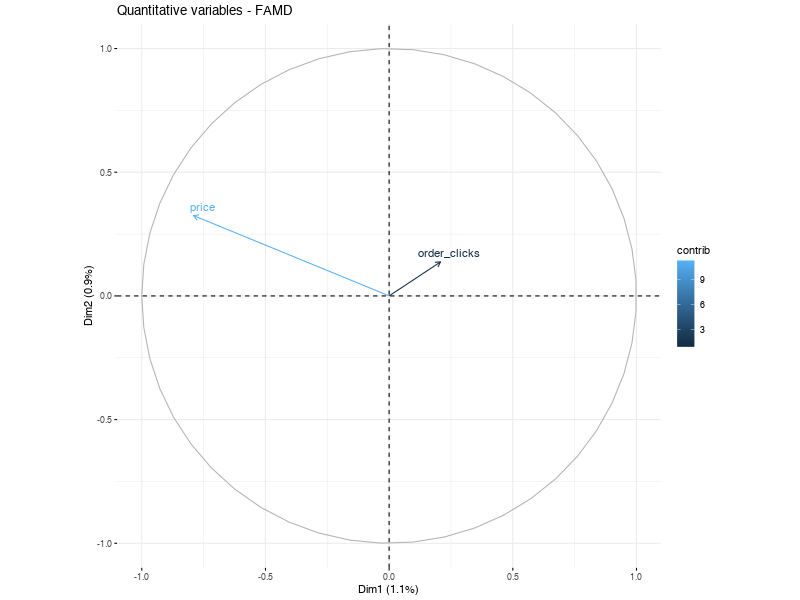

In [79]:
quant_vars_plot = facto_extra.fviz_famd_var(
    X = famd_result, 
    choice = "quanti.var", 
    col_var = "contrib", 
    repel = True
)

image_png(quant_vars_plot, width=800, height=600)

The two-dimensional coordinates can be plotted as: 

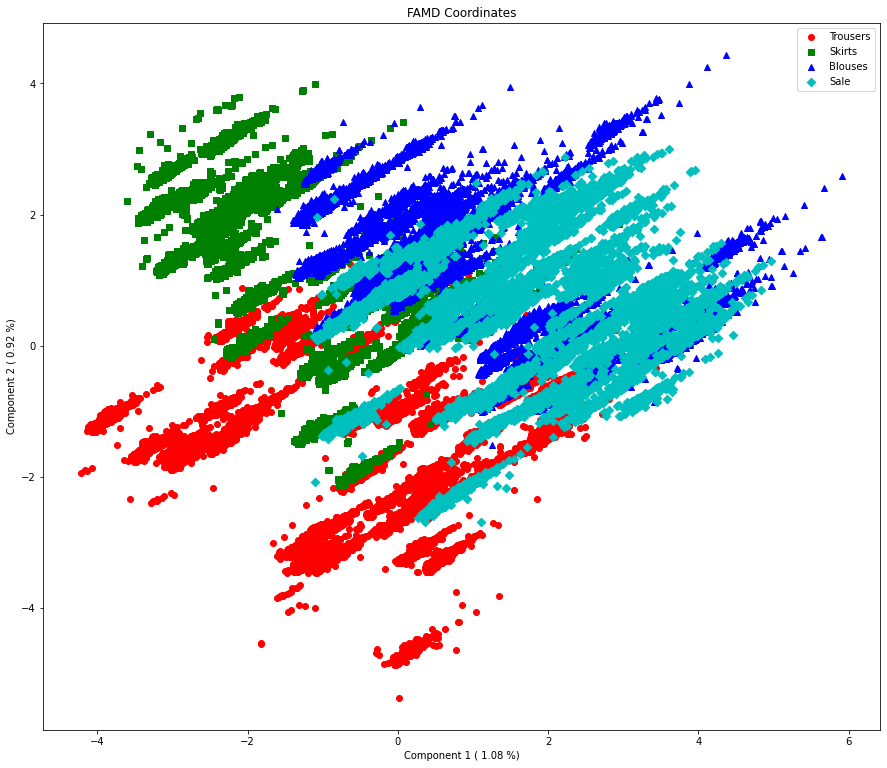

In [118]:
famd_coords = np.array(famd_result.rx2('ind').rx2('coord'))[:, :2]
main_prod_category = df.page_main_prod_category.values.astype(np.int8) - 1 # Convert to 0-based indexing
comp_1_exp_inertia = famd_exp_var.loc['comp_1', 'percentage_of_inertia']
comp_2_exp_inertia = famd_exp_var.loc['comp_2', 'percentage_of_inertia']

# Define a color map and markers for each product category
colors = ['r', 'g', 'b', 'c']
markers = ['o', 's', '^', 'D']

# Create the scatter plot
fig, ax = plt.subplots(figsize=fig_size)
for c in np.unique(main_prod_category):
    mask = main_prod_category == c
    ax.scatter(famd_coords[:, 0][mask], famd_coords[:, 1][mask], c=colors[c], marker=markers[c])
    
# Add axis labels and show the plot
plt.xlabel(f'Component 1 ({comp_1_exp_inertia: .2f} %)')
plt.ylabel(f'Component 2 ({comp_2_exp_inertia: .2f} %)')
plt.title('FAMD Coordinates')
plt.legend(['Trousers', 'Skirts', 'Blouses', 'Sale'])
plt.show();

One of the options for clustering with mixed data is to use these coordinates as inputs to the clustering model. But in this case, the FAMD technique does not lead to good analysis, and so we will proceed to try another approach. 

## Gower Distance

Gower’s distance can be used to measure how different two data points are. The data points may contain combinations of logical, numerical, categorical or text data. The distance is always a number between 0 (identical) and 1 (maximally dissimilar). 

For features $x_i=x_{i 1}, \ldots, x_{i p}$ and $x_j=x_{j 1}, \ldots, x_{j p}$ (both are vectors in $\mathbb{R}^{p}$), the Gower similarity matrix can be defined as
$$
S_{\text {Gower }}\left(x_i, x_j\right)=\frac{\sum_{k=1}^p s_{i j k} \delta_{i j k}}{\sum_{k=1}^p \delta_{i j k}} .
$$
For each feature $k=1, \ldots, p$ 

* a score $s_{i j k}$ is calculated
* a quantity $\delta_{i j k}$ is also calculated having possible values 0, 1 depending on whether the variables $x_i$ and $x_j$ can be compared or not (e.g. if they have different types)

A special case for when no missing values exist can be formulated as the mean of the Gower similarity scores, that is:

$$
S_{\text {Gower}}\left(x_i, x_j\right)=\frac{\sum_{k=1}^p s_{i j k}}{p}
$$

Note that $p$ is the number of features or dimensions of a data point $x_{i}$. The score $s_{i j k}$ calculation will depend on the type of variable. This similarity score will take values between $0 \leq s_{i j k} \leq 1$ with 0 representing maximum similarity and 1 no similarity.

### Numerical Variable Scoring

For numerical variables, the score can be calculated as:
$$
s_{i j k}=1-\frac{\left|x_{i k}-x_{j k}\right|}{R_k} .
$$
This is simply an $\underline{\mathrm{L} 1}$ distance between the two values normalized by a quantity $R_k$. The quantity $R_k$ refers to the range of feature  $k$ (population or sample). The range quantity can often be taken as the difference between the sample maximum and minimum for feature $k$. Therefore, scaling the numerical features using standardization (or robust scaler) is important since different features may have different range values, thus influencing the similarity scoring. 

### Categorical Variable Scoring

For categorical variables, the score is calculated as:
$$
s_{i j k}=1 x_{i k}=x_{j k}
$$
This score will be 1 if the categories are the same and 0 if they are not (**opposite of how we interpret the actual gower similarity score**). 

In reality the score $S_{\text {Gower }}\left(x_i, x_j\right)$ will be a similarity score taking values between 1 (for equal data points) and 0 for extremely dissimilar data points. In order to turn this value into a distance metric we can convert it using (for instance)
$$
d_{\text {Gower }}=\sqrt{1-S_{\mathrm{Gower}}}
$$
This distance metric will take values of 1 for the furthest points and 0 for the same points. So, to summarize:

* For categorical variables, $s_{i j k}=1$ means that the two data points agree and $s_{i j k}=0$ means that they differ

* For gower's similarity score, $S_{\text {Gower}}=1$ means that the two data points are identical and $S_{\text {Gower}}=0$ means they differ maximally.

* Finally, the distance metric has the exact opposite interpretation--- $d_{\text {Gower }}=1$ means two points are very far away and $d_{\text {Gower }}=0$ means that two points are close.

In [10]:
df_gower = df.drop(columns=['session_id', 'year'])

month_map = {4: 'April',
             5: 'May',
             6: 'June',
             7: 'July',
             8: 'August'}

day_map = {i: 'day_' + str(i) for i in range(1, 32)}

country_map = {1: 'Australia',
               2: 'Austria',
               3: 'Belgium',
               4: 'British Virgin Islands',
               5: 'Cayman Islands',
               6: 'Christmas Island',
               7: 'Croatia',
               8: 'Cyprus',
               9: 'Czech Republic',
               10: 'Denmark',
               11: 'Estonia',
               12: 'Unidentified',
               13: 'Faroe Islands',
               14: 'Finland',
               15: 'France',
               16: 'Germany',
               17: 'Greece',
               18: 'Hungary',
               19: 'Iceland',
               20: 'India',
               21: 'Ireland',
               22: 'Italy',
               23: 'Latvia',
               24: 'Lithuania',
               25: 'Luxembourg',
               26: 'Mexico',
               27: 'Netherlands',
               28: 'Norway',
               29: 'Poland',
               30: 'Portugal',
               31: 'Romania',
               32: 'Russia',
               33: 'San Marino',
               34: 'Slovakia',
               35: 'Slovenia',
               36: 'Spain',
               37: 'Sweden',
               38: 'Switzerland',
               39: 'Ukraine',
               40: 'United Arab Emirates',
               41: 'United Kingdom',
               42: 'USA',
               43: 'biz (*.biz)',
               44: 'com (*.com)',
               45: 'int (*.int)',
               46: 'net (*.net)',
               47: 'org (*.org)'}

main_category_map = {1: 'Trousers',
                     2: 'Skirts',
                     3: 'Blouses',
                     4: 'Sale'}

color_map = {1: 'Beige',
              2: 'Black',
              3: 'Blue',
              4: 'Brown',
              5: 'Burgundy',
              6: 'Gray',
              7: 'Green',
              8: 'Navy Blue',
              9: 'Of many colors',
              10: 'Olive',
              11: 'Pink',
              12: 'Red',
              13: 'Violet',
              14: 'White'}

location_map = {1: 'Top left',
                2: 'Top in the middle',
                3: 'Top right',
                4: 'Bottom left',
                5: 'Bottom in the middle',
                6: 'Bottom right'}

model_photography_map = {1: 'En face',
                         2: 'Profile'}

price2_map = {1: 'Yes',
              2: 'No'}

page_number_map = {i: 'page_' + str(i) for i in range(1, 6)}

# Convert numeric categorical back to string representations
for col, mapping in zip(['month', 'day', 'country', 'page_main_prod_category', 'prod_color', 'photo_location', 'model_photo', 'price_higher_avg', 'page_number'], [month_map, day_map, country_map, main_category_map, color_map, location_map, model_photography_map, price2_map, page_number_map]):
    df_gower[col] = df_gower[col].astype(np.int16).map(mapping)

Take a sample of 1,000 rows to shorten computation time (neither `scikit-learn` nor `cuml` has implemented an optimized version this distance metric):

In [11]:
# Sample and robust scaling
df_sampled = ColumnTransformer([('scaled', RobustScaler(), num_cols)], remainder='passthrough').fit_transform(df_gower.sample(1000))
# Remove prefix from column names
df_sampled.columns = [sub('scaled__|remainder__', '', col) for col in df_sampled.columns]

# Compute Gower distance matrix
gower_mat = gower_matrix(df_sampled, cat_features=None).astype(np.float64)
gower_mat

array([[0.        , 0.78776044, 0.69843751, ..., 0.60677081, 0.74635416,
        0.69921875],
       [0.78776044, 0.        , 0.50703126, ..., 0.52473956, 0.63828123,
        0.52083331],
       [0.69843751, 0.50703126, 0.        , ..., 0.43541667, 0.46562499,
        0.51484376],
       ...,
       [0.60677081, 0.52473956, 0.43541667, ..., 0.        , 0.55624998,
        0.50911456],
       [0.74635416, 0.63828123, 0.46562499, ..., 0.55624998, 0.        ,
        0.63046873],
       [0.69921875, 0.52083331, 0.51484376, ..., 0.50911456, 0.63046873,
        0.        ]])

## Multidimensional Scaling

Once we obtain the gower matrix, we can use a (non-linear) dimensionality reduction technique to find a lower dimensional representation of the distance (dissimilarity) matrix before applying clustering.

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

The classical multidimensional scaling is also known as **Principal Coordinates Analysis (PCoA)**, Torgerson Scaling or Torgerson-Gower scaling. It takes an input matrix giving dissimilarities between pairs of items and outputs a coordinate matrix whose configuration minimizes a loss function called strain, which is given by
$$
\operatorname{Strain}_D\left(x_1, x_2, \ldots, x_N\right)=\left(\frac{\sum_{i, j}\left(b_{i j}-x_i^T x_j\right)^2}{\sum_{i, j} b_{i j}^2}\right)^{1 / 2}
$$
where 

* $x_i$ denote data points (vectors) in $N$-dimensional space
* $x_i^T x_j$ denotes the scalar matrix product (dot product) between vectors $x_i$ and $x_j$
* $b_{i j}$ are the elements of the matrix $B$ defined on step 2 of the following algorithm, which are computed from the distances
  
### Steps of a Classical MDS algorithm

Classical MDS uses the fact that the coordinate matrix $X$ can be derived by eigenvalue decomposition from $B=X X^{\prime}$. And the matrix $B$ can be computed from proximity matrix $D$ by using double centering.

1. Set up the squared proximity matrix $D^{(2)}=\left[d_{i j}^2\right]$, where $d_{i j}$ is the euclidean distance between $x_{i}$ and $x_{j}$
2. Apply double centering: $B=-\frac{1}{2} C D^{(2)} C$ using the centering matrix $C=I-\frac{1}{n} J_n$, where 
    * $n$ is the number of objects
    * $I$ is the $n \times n$ identity matrix
    *  $J_n$ is an $n \times n$ matrix of all ones
3. Determine the $m$ largest eigenvalues $\lambda_1, \lambda_2, \ldots, \lambda_m$ and corresponding eigenvectors $e_1, e_2, \ldots, e_m$ of $B$ (where $m$ is the number of dimensions desired for the output).
4. Now, $X=E_m \Lambda_m^{1 / 2}$, where 
    * $E_m$ is the matrix of $m$ eigenvectors 
    * $\Lambda_m$ is the diagonal matrix of $m$ eigenvalues of $B$
   
The classical MDS assumes euclidean distances. So this is not applicable for direct dissimilarity ratings.

### Metric multidimensional scaling (mMDS)

This algorithm is a superset of the classical MDS that generalizes the optimization procedure to a variety of loss functions and input matrices of known distances (not just euclidean) with weights and so on. A useful loss function in this context is called **stress**, which is often minimized using a procedure called stress majorization. Metric MDS minimizes the cost function called "stress" which is a residual sum of squares:
$$
\operatorname{Stress}_D\left(x_1, x_2, \ldots, x_N\right)=\sqrt{\sum_{i \neq j=1, \ldots, N}\left(d_{i j}-\left\|x_i-x_j\right\|_{2}\right)^2}
$$

### More Details

The data to be analyzed is a collection of $M$ objects (colors, faces, stocks, ...) on which a distance function is defined, $d_{i, j}:=$ distance between $i$-th and $j$-th objects.

These distances are the entries of the dissimilarity matrix
$$
D:=\left(\begin{array}{cccc}
d_{1,1} & d_{1,2} & \cdots & d_{1, M} \\
d_{2,1} & d_{2,2} & \cdots & d_{2, M} \\
\vdots & \vdots & & \vdots \\
d_{M, 1} & d_{M, 2} & \cdots & d_{M, M}
\end{array}\right)
$$

The goal of MDS is, given $D$, to find $M$ vectors $x_1, \ldots, x_M \in \mathbb{R}^N$ such that
$$
\left\|x_i-x_j\right\| \approx d_{i, j} \text { for all } i, j \in 1, \ldots, M,
$$
where $\|\cdot\|$ is a vector norm. In classical MDS, this norm is the Euclidean distance, but, in a broader sense, it may be a metric or arbitrary distance function. 

In other words, MDS attempts to find a mapping from the $M$ objects into $\mathbb{R}^N$ *such that distances are preserved*. If the dimension $N$ is chosen to be 2 or 3, we may plot the vectors $x_i$ to obtain a visualization of the similarities between the $M$ objects. Put it another way, if we do not have the original data matrix of $M$ training examples and $N$ features but only the $M \times M$ distance matrix, we still would like to find vectors $x_1, \ldots, x_M \in \mathbb{R}^N$ such that these pairwise distance between training examples are preserved as close as possible.

Note that the vectors $x_i$ are not unique. With the distance, they may be arbitrarily translated, rotated, and reflected, since these transformations do not change the pairwise distances $\left\|x_i-x_j\right\|$.

(Note: The symbol $\mathbb{R}$ indicates the set of real numbers, and the notation $\mathbb{R}^N$ refers to the Cartesian product of $N$ copies of $\mathbb{R}$, which is an $N$-dimensional vector space over the field of the real numbers.)

There are various approaches to determining the vectors $x_i$. Usually, MDS is formulated as an optimization problem, where $\left(x_1, \ldots, x_M\right)$ is found as a minimizer of some cost function, for example,
$$
\underset{x_1, \ldots, x_M}{\operatorname{argmin}} \sum_{i<j}\left(\left\|x_i-x_j\right\|-d_{i, j}\right)^2 .
$$
A solution may then be found by numerical optimization techniques. For some particularly chosen cost functions, minimizers can be stated analytically in terms of matrix eigen-decompositions. 

In [13]:
stress_scores = {}
n_components_list = [2, 10, 20, 50, 100, 300, 500, 700]
for n_components in tqdm(n_components_list):
    mds_model = MDS(
        n_components=n_components,
        metric=True,
        n_init=4, # Number of times the algorithm will be run with different initial centroid seeds
        max_iter=300, # Maximum number of iterations of the SMACOF (Scaling by Majorizing a COmplicated Function) algorithm for a single run
        n_jobs=-1,
        random_state=rs,
        dissimilarity='precomputed', # Use precomputed distance matrix
        normalized_stress='auto'
    ).fit(gower_mat)
    stress_scores[f'{n_components} components'] = mds_model.stress_

  0%|          | 0/8 [00:00<?, ?it/s]<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
 12%|█▎        | 1/8 [00:08<00:59,  8.50s/it]<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C he

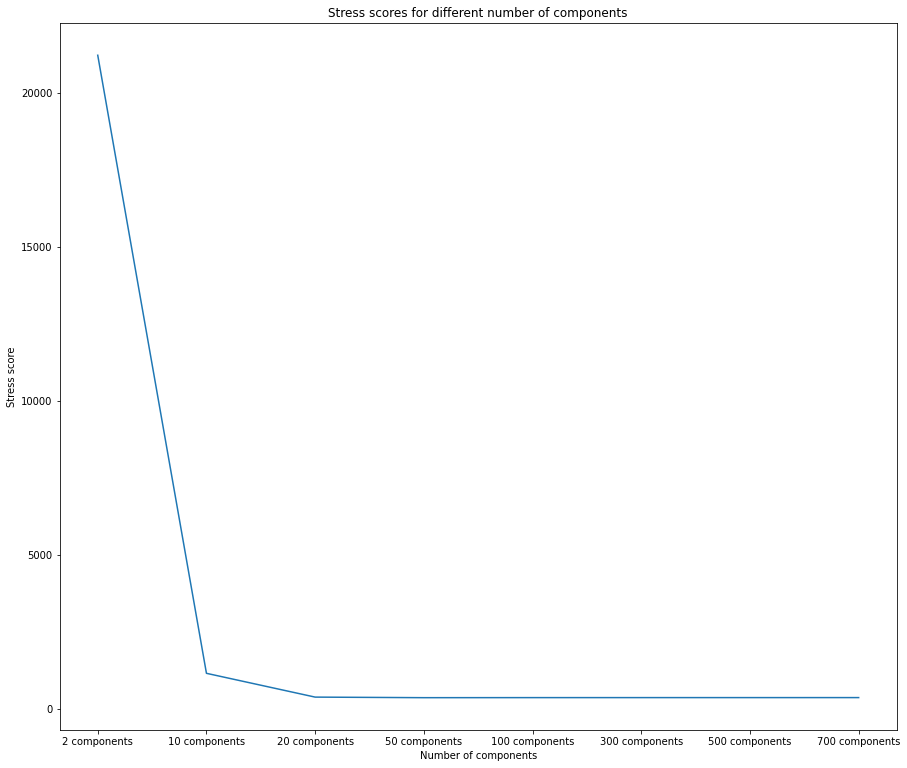

In [14]:
# Plot stress scores
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(list(stress_scores.keys()), list(stress_scores.values()))
ax.set_xlabel('Number of components')
ax.set_ylabel('Stress score')
ax.set_title('Stress scores for different number of components')
plt.show();

Using the kneedle algorithm, the heuristic optimal number of components can be found as follows:

In [15]:
# If 'concave', algorithm will detect knees and if 'convex', it will detect elbows
kneedle = KneeLocator(n_components_list, list(stress_scores.values()), curve='convex', direction='decreasing')

print(f'Optimal number of components: {kneedle.knee}')

Optimal number of components: 20


Now, we fit the new MDS model:

In [16]:
# Fit MDS with optimal number of components
mds_model = MDS(
    n_components=kneedle.knee,
    metric=True,
    n_init=4, # Number of times the algorithm will be run with different initial centroid seeds
    max_iter=300, # Maximum number of iterations of the SMACOF (Scaling by Majorizing a COmplicated Function) algorithm for a single run
    n_jobs=-1,
    random_state=rs,
    dissimilarity='precomputed', # Use precomputed distance matrix
    normalized_stress='auto'
)

mds_mappings = mds_model.fit_transform(gower_mat)
mds_mappings.shape

(1000, 20)

In [17]:
mds_mappings

array([[ 1.48640242e-01, -1.25307955e-04,  1.33127409e-01, ...,
        -2.33369803e-02, -1.70365674e-01, -4.33046280e-02],
       [-5.21946509e-02, -7.75548454e-02, -1.43080786e-02, ...,
         1.20571731e-01,  8.97854217e-02,  9.43049995e-02],
       [ 2.53195880e-02,  4.98011635e-02, -4.64999249e-02, ...,
         4.34524808e-04,  9.18044609e-02, -1.57311376e-03],
       ...,
       [ 1.28736851e-01, -2.64249599e-03, -1.41774889e-02, ...,
        -5.13606495e-02,  5.64469649e-02,  4.08733594e-02],
       [ 2.43389832e-02,  9.45860223e-02,  9.30839491e-02, ...,
        -3.90369472e-02, -3.66503080e-02,  4.36700582e-02],
       [ 9.80652332e-02, -2.54891622e-02, -2.16290308e-01, ...,
        -5.48116092e-03,  3.36619422e-02,  5.27195239e-02]])

## Clustering Using Gower Distance

The 20-dimensional representation of the Gower distance matrix can now be used for visualizing the clustering outputs. 

### HDBSCAN

HDBSCAN has two important parameters to tune:

* The larger the value of `min_samples`, the more conservative the clustering–-- i.e., more points will be declared as noise, and clusters will be restricted to progressively more dense areas.

* With `min_samples` fixed, the primary parameter to effect the resulting clustering is `min_cluster_size`. Set it to the smallest size grouping that we wish to consider a cluster; in other words, increasing this parameter leads the algorithm to create denser clusters with more data points, thus reducing the number of clusters.

In [18]:
sc_scores_hdbscan_min_sample = []
min_samples_range = np.arange(5, 50, 1)

for min_samples in tqdm(min_samples_range):
    hdbscan = HDBSCAN(min_cluster_size=5, min_samples=min_samples, metric='precomputed') # Use default values for other parameters
    hdbscan.fit(gower_mat)
    sc_scores_hdbscan_min_sample.append(silhouette_score(X=gower_mat, labels=hdbscan.labels_, metric='precomputed'))

100%|██████████| 45/45 [00:03<00:00, 12.57it/s]


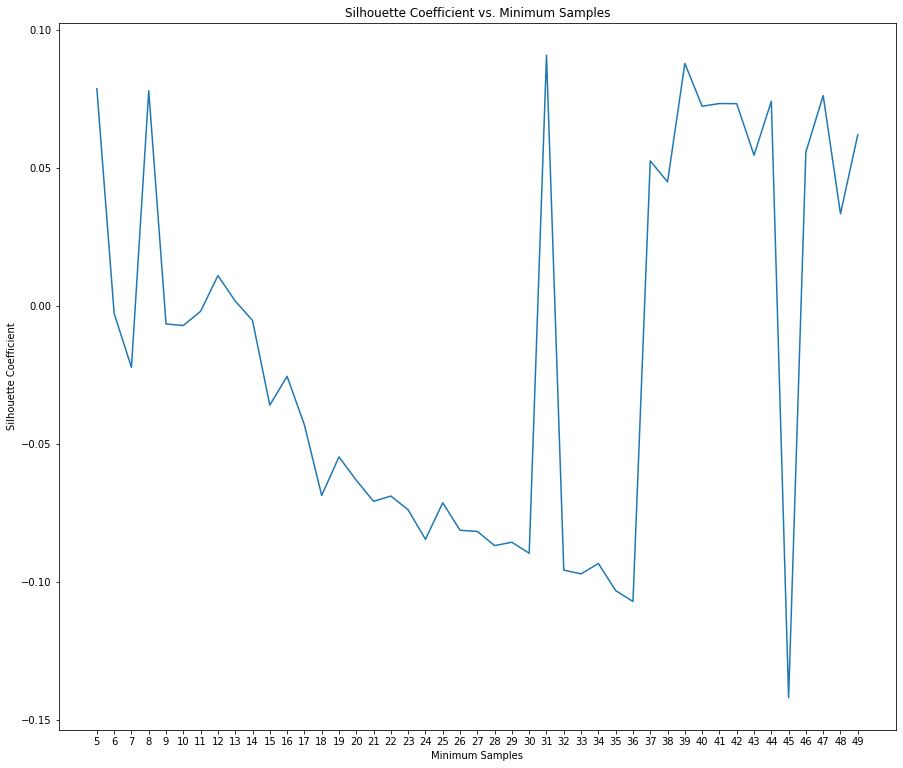

In [19]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(min_samples_range, sc_scores_hdbscan_min_sample, label='Silhouette score')
plt.xlabel('Minimum Samples')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient vs. Minimum Samples')
plt.xticks(min_samples_range)
plt.show();

For both metics, the higher the score the better. Using visual heuristics, we will choose `min_samples=8`. Now, we fix `min_samples` and tune the `min_cluster_size`: 

In [36]:
sc_scores_hdbscan_min_cluster_size = []
num_clusters_hdbscan = []
min_cluster_size_range = np.arange(5, 40, 2)

for min_cluster_size in tqdm(min_cluster_size_range):
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=8, metric='precomputed')
    hdbscan.fit(gower_mat)
    num_clusters_hdbscan.append(len(set(hdbscan.labels_)))
    sc_scores_hdbscan_min_cluster_size.append(silhouette_score(X=gower_mat, labels=hdbscan.labels_, metric='precomputed'))

100%|██████████| 18/18 [00:01<00:00,  9.68it/s]


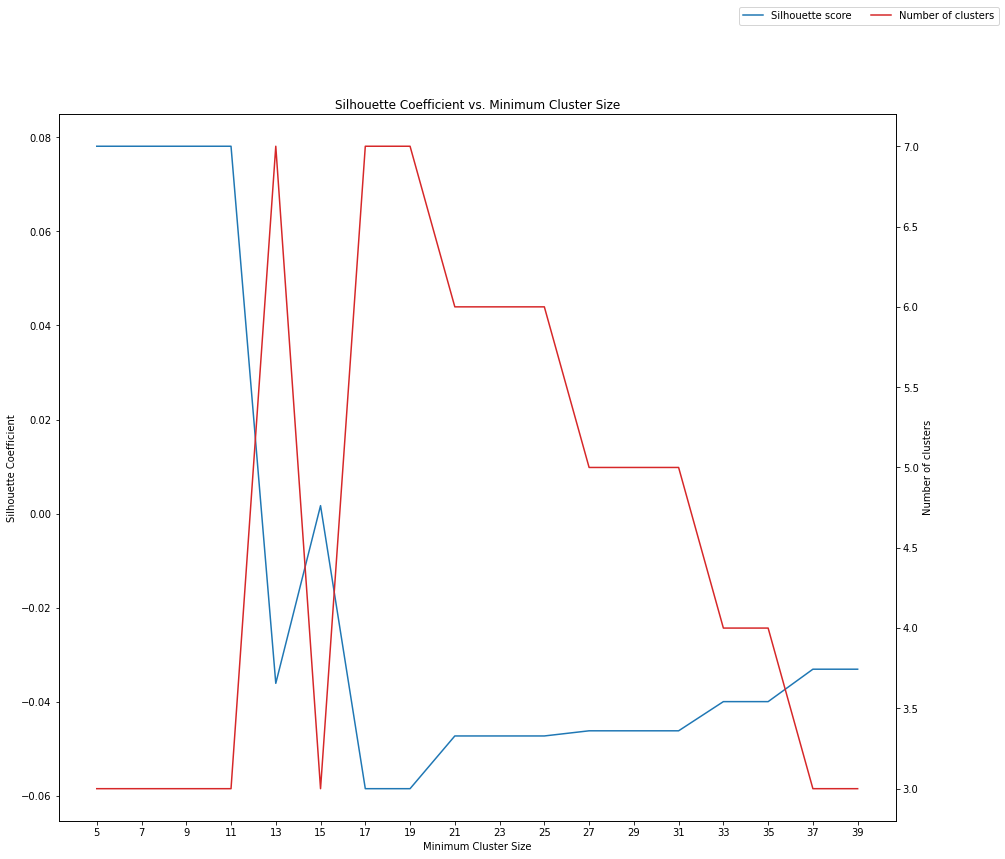

In [46]:
fig, ax1 = plt.subplots(figsize=fig_size)

# First plot (left y-axis)
ax1.plot(min_cluster_size_range, sc_scores_hdbscan_min_cluster_size, label='Silhouette score', color='tab:blue')
ax1.set_xlabel('Minimum Cluster Size')
ax1.set_ylabel('Silhouette Coefficient')
ax1.set_title('Silhouette Coefficient vs. Minimum Cluster Size')
ax1.set_xticks(min_cluster_size_range)

# Second plot (right y-axis)
ax2 = ax1.twinx()
ax2.plot(min_cluster_size_range, num_clusters_hdbscan, label='Number of clusters', color='tab:red')
ax2.set_ylabel('Number of clusters')

fig.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2)
plt.show();

We see that `min_cluster_size=11` seems to be the best for the Silhouette score. We will choose `min_cluster_size=11`, since the number of clusters of 3 (plus one for outliers) is manageable for downstream business interpretation.

In [47]:
hdbscan_model = HDBSCAN(min_cluster_size=11, min_samples=8, metric='precomputed')

hdbscan_model.fit(gower_mat)

HDBSCAN(metric='precomputed', min_cluster_size=11, min_samples=8)

Finally, we visualize the output of the clustering model using the first two MDS mappings:

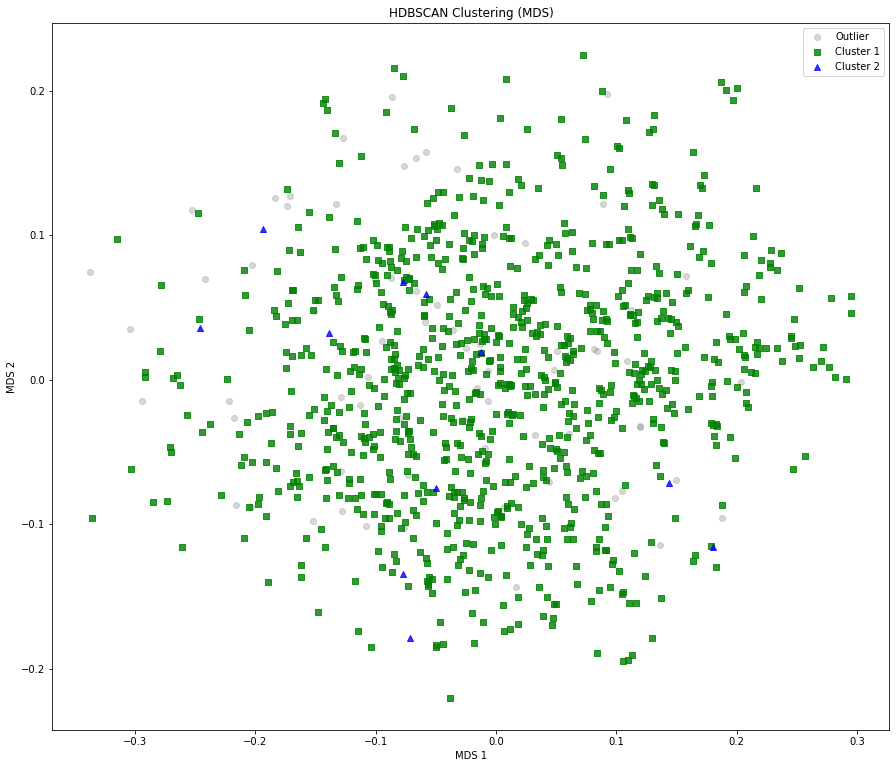

In [48]:
# Data for plotting
x = mds_mappings[:, 0]
y = mds_mappings[:, 1]
c_hdbscan = hdbscan_model.labels_

# Define a color map and markers for each cluster (-1 represents the outliers)
colors = ['grey', 'g', 'b']
markers = ['o', 's', '^']
alpha = [0.3, 0.8, 0.8]

# Create the scatter plot
fig, ax = plt.subplots(figsize=fig_size)
for index, c in np.ndenumerate(np.unique(c_hdbscan)):
    mask = c_hdbscan == c
    ax.scatter(x[mask], y[mask], c=colors[index[0]], marker=markers[index[0]], alpha=alpha[index[0]])
    
# Add axis labels and show the plot
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.title('HDBSCAN Clustering (MDS)')
plt.legend(['Outlier', 'Cluster 1', 'Cluster 2'])
plt.show();

Finally, we add the cluster labels to the sampled data:

In [51]:
df_sampled['hdbscan_cluster'] = hdbscan_model.labels_
df_sampled['hdbscan_cluster'].head(5)

50666     0
159388    0
37750     0
40494     0
108913    0
Name: hdbscan_cluster, dtype: int64

### KMediods

Both the k-means and k-medoids algorithms are **partitional** (breaking the dataset up into groups) and attempt to minimize the distance between points labeled to be in a cluster and a point designated as the center of that cluster. 

In contrast to the k-means algorithm, k-medoids chooses *actual data points* as centers (medoids or exemplars or prototypes), and thereby allows for greater interpretability of the cluster centers than in k-means, where the center of a cluster is not necessarily one of the input data points (*it is the average between the points in the cluster*). 

Furthermore, k-medoids can be used with arbitrary dissimilarity measures, whereas k-means generally requires *Euclidean* distance for efficient solutions. Because **k-medoids minimizes a sum of pairwise dissimilarities** instead of a sum of squared Euclidean distances, it is more robust to noise and outliers than k-means.

### Partitioning Around Medoids (PAM) 

PAM uses a greedy search which may not find the optimum solution, but it is faster than exhaustive search. It works as follows:

1. (BUILD) Initialize: greedily select $k$ of the $n$ data points as the medoids to minimize the cost
   
2. Associate each data point to the closest medoid.
   
3. (SWAP) While the cost of the configuration decreases:
   
   1. For each medoid $m$, and for each non-medoid data point $o$:
   
      1. Consider the swap of $m$ and $o$, and compute the cost change
   
      2. If the cost change is the current best, remember this $m$ and $o$ combination
   
   2. Perform the best swap of $m_{\text {best }}$ and $o_{\text {best }}$, if it decreases the cost function. Otherwise, the algorithm terminates.

In the `scikit-learn-extra` package, the complexity of K-Medoids is $O\left(N^2 K T\right)$ where 

* $N$ is the number of samples
* $T$ is the number of iterations
* $K$ is the number of clusters

This is a naive implementation that recomputes the entire cost function every iteration, making it more suitable for smaller datasets in comparison to KMeans which is $O(N K T)$.

In [52]:
sc_scores_kmediods = []
k_mediods_range = range(3, 20)

for n_clusters in tqdm(k_mediods_range):
    kmediods_model = KMedoids(
        n_clusters=n_clusters,
        metric='precomputed', 
        method='pam',
        init='k-medoids++', # The original 'build' method can be may be slower than other initialization methods
        random_state=rs
        )
    kmediods_model.fit(gower_mat)
    sc_scores_kmediods.append(silhouette_score(X=gower_mat, labels=kmediods_model.labels_, metric='precomputed'))

100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


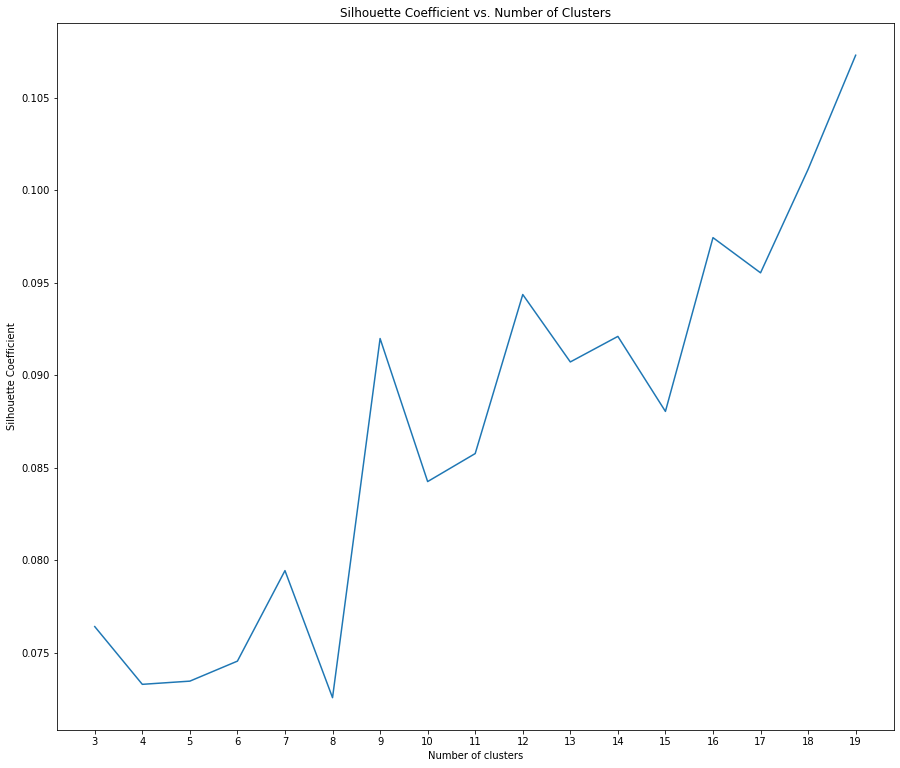

In [53]:
fig, ax1 = plt.subplots(figsize=fig_size)

# First plot (left y-axis)
ax1.plot(k_mediods_range, sc_scores_kmediods, label='Silhouette score')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Coefficient')
ax1.set_title('Silhouette Coefficient vs. Number of Clusters')
ax1.set_xticks(k_mediods_range)

plt.show();

Using visual heuristics, the highest scores are associated with 17 or 19 clusters. Using the kneedle algorithm:

In [55]:
kneedle = KneeLocator(k_mediods_range, sc_scores_kmediods, curve='concave', direction='increasing')
print(f'Optimal number of clusters: {kneedle.knee}')

Optimal number of clusters: 3


Although the visual assessment leads us to conclude more number of clusters, fewer number of clusters in this case may actually aid business interpretation and make the results of K Mediods more comparable to those of HDBSCAN, which produced 2 non-outlaying clusters. 

In [56]:
kmediods_model = KMedoids(
    n_clusters=3,
    metric='precomputed', 
    method='pam',
    init='k-medoids++', # The original 'build' method can be may be slower than other initialization methods
    random_state=rs,
    max_iter=1000
)

kmediods_model.fit(gower_mat)

KMedoids(init='k-medoids++', max_iter=1000, method='pam', metric='precomputed',
         n_clusters=3, random_state=RandomState(MT19937) at 0x7FC610DED940)

Now, we can visualize the output as follows:

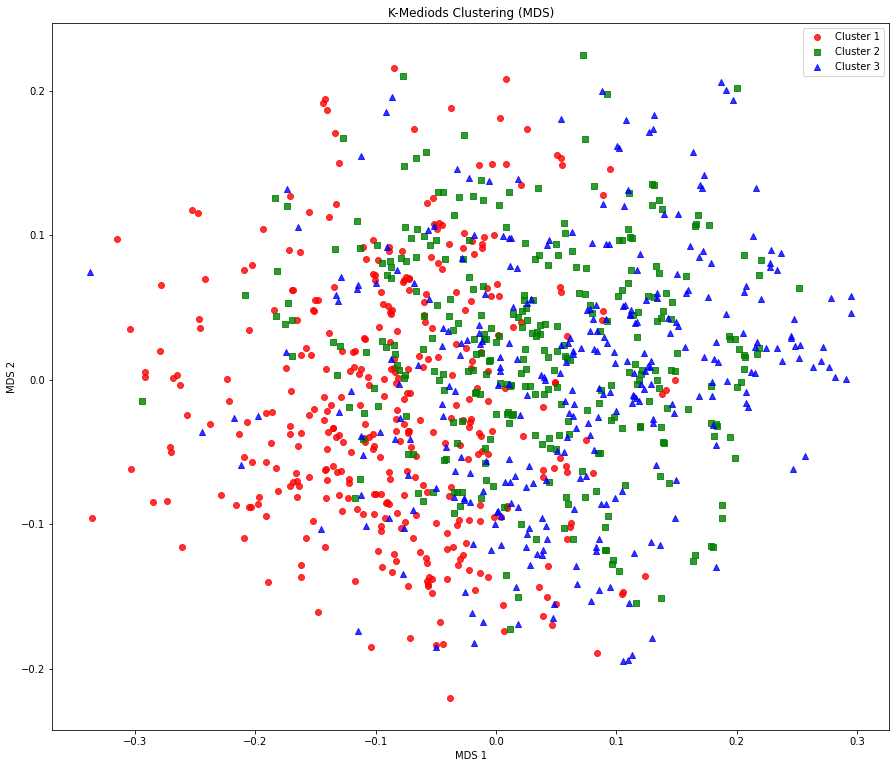

In [57]:
# Data for plotting
c_kmediods = kmediods_model.labels_

# Define a color map and markers for each cluster
colors = ['r', 'g', 'b']
markers = ['o', 's', '^']
alpha = [0.8] * len(colors)

# Create the scatter plot
fig, ax = plt.subplots(figsize=fig_size)
for index, c in np.ndenumerate(np.unique(c_kmediods)):
    mask = c_kmediods == c
    ax.scatter(x[mask], y[mask], c=colors[index[0]], marker=markers[index[0]], alpha=alpha[index[0]])
    
# Add axis labels and show the plot
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.title('K-Mediods Clustering (MDS)')
plt.legend(['Cluster ' + str(i) for i in range(1, len(colors) + 1)])
plt.show();

Add the labels to the sampled data:

In [58]:
df_sampled['kmediods_cluster'] = kmediods_model.labels_
df_sampled['kmediods_cluster'].head(5)

50666     0
159388    1
37750     1
40494     1
108913    2
Name: kmediods_cluster, dtype: int64

### Agglomerative Clustering

We start with the default number of clusters (`n_clusters=2`) and choose the linkage method that leads to the best performance in terms the silhouette score:

In [388]:
linkage_criteria = ['single', 'complete', 'average'] # Ward linkage is not supported for precomputed distance matrices
sc_scores_agglomerative_linkage = []

for linkage in tqdm(linkage_criteria):
    agg_model = AgglomerativeClustering(
        metric='precomputed',
        linkage=linkage
    )
    agg_model.fit(gower_mat)
    sc_scores_agglomerative_linkage.append(silhouette_score(gower_mat, agg_model.labels_, metric='precomputed'))

100%|██████████| 3/3 [00:00<00:00, 28.58it/s]


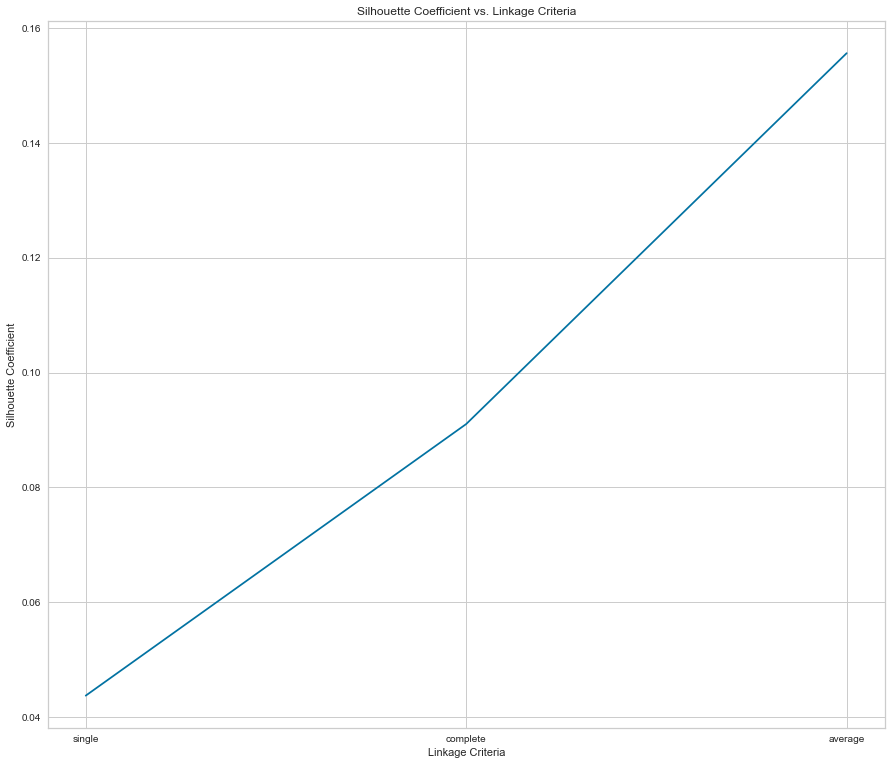

In [390]:
# Comparing the different linkage criteria
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(linkage_criteria, sc_scores_agglomerative_linkage, label='Silhouette score')
ax.set_xlabel('Linkage Criteria')
ax.set_ylabel('Silhouette Coefficient')
ax.set_title('Silhouette Coefficient vs. Linkage Criteria')
plt.show();

Based on the results, we will use the average linkage criterion, which minimizes the average of the distances between all observations of pairs of clusters. Now, we hold the linkage criterion fixed and tune the number of clusters:

In [406]:
k_agglomerative_range = range(3, 20)
sc_scores_agglomerative = []

for n_clusters in tqdm(k_agglomerative_range):
    agg_model = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='precomputed',
        linkage='average'
    )
    agg_model.fit(gower_mat)
    sc_scores_agglomerative.append(silhouette_score(gower_mat, agg_model.labels_, metric='precomputed'))

100%|██████████| 17/17 [00:00<00:00, 43.82it/s]


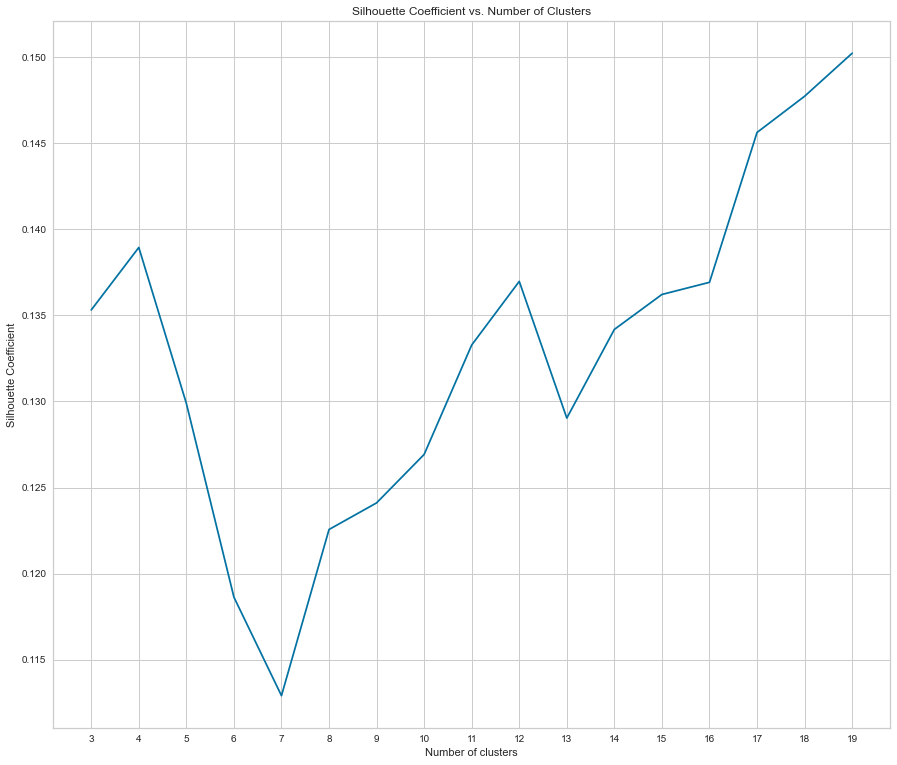

In [407]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(k_agglomerative_range, sc_scores_agglomerative, label='Silhouette score')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Coefficient')
ax.set_title('Silhouette Coefficient vs. Number of Clusters')
ax.set_xticks(k_agglomerative_range)
plt.show();

Again, using the kneedle algorithms:

In [408]:
kneedle = KneeLocator(k_agglomerative_range, sc_scores_agglomerative, curve='concave', direction='increasing')
print(f'Optimal number of clusters: {kneedle.knee}')

Optimal number of clusters: 4


In [410]:
agg_model = AgglomerativeClustering(
    n_clusters=4,
    metric='precomputed',
    linkage='average',
    compute_distances=True
)

agg_model.fit(gower_mat)

AgglomerativeClustering(compute_distances=True, linkage='average',
                        metric='precomputed', n_clusters=4)

Plotting the results:

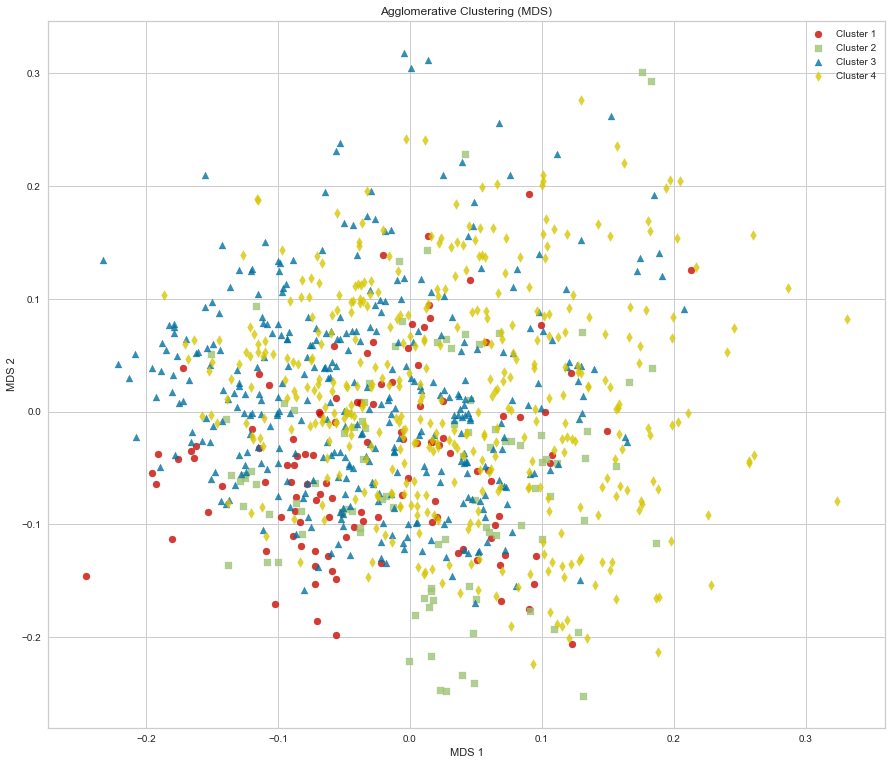

In [411]:
# Data for plotting
c_agglomerative = agg_model.labels_

# Define a color map and markers for each cluster
colors = ['r', 'g', 'b', 'y']
markers = ['o', 's', '^', 'd']
alpha = [0.8] * len(colors)

# Create the scatter plot
fig, ax = plt.subplots(figsize=fig_size)
for index, c in np.ndenumerate(np.unique(c_agglomerative)):
    mask = c_agglomerative == c
    ax.scatter(x[mask], y[mask], c=colors[index[0]], marker=markers[index[0]], alpha=alpha[index[0]])
    
# Add axis labels and show the plot
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.title('Agglomerative Clustering (MDS)')
plt.legend(['Cluster ' + str(i) for i in range(1, len(colors) + 1)])
plt.show();

With agglomerative clustering and smaller data sets, we can actually visualize its corresponding dendrogram if we set `compute_dinstance` to true:

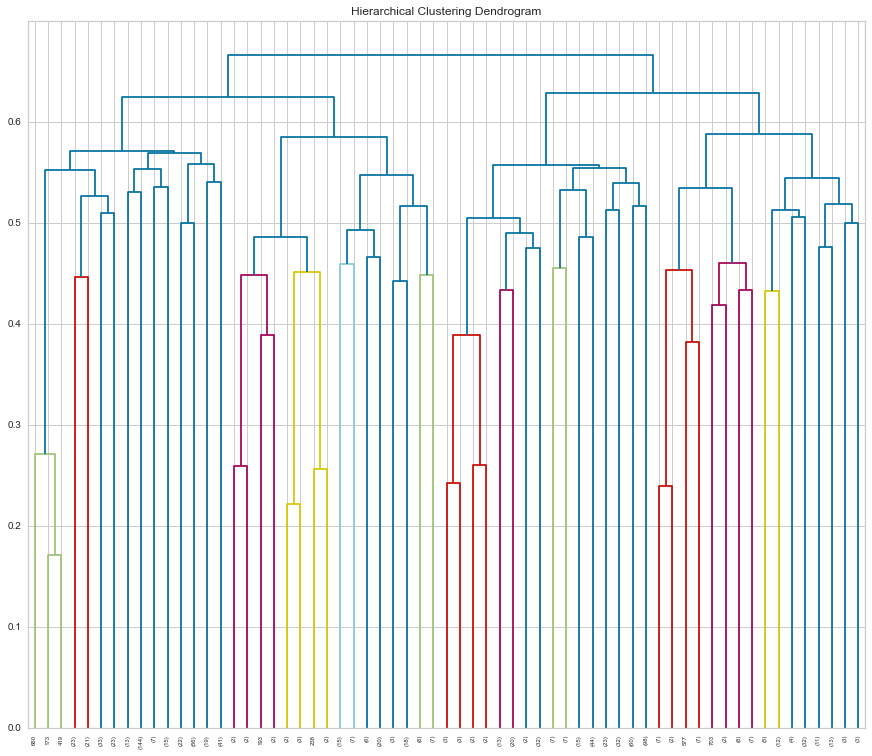

In [425]:
# Size of the dendrogram
plot_dendrogram(agg_model, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
fig = plt.gcf()
fig.set_size_inches(*fig_size)
plt.show();

## Clustering Using K-Prototype

Let $\boldsymbol{X}=\left\{X_1, X_2, \ldots, X_n\right\} \in \mathbb{R}^{n\times m}$ denote a set of $n$ objects (rows of data matrix) and $X_i=\left[x_{i 1}, x_{i 2}, \ldots, x_{i m}\right] \in \mathbb{R}^{1 \times m}$ be an object represented by $m$ attribute (features) values. Let $k$ be a positive integer. The objective of clustering $\boldsymbol{X}$ is to find a partition which divides objects in $\boldsymbol{X}$ into $k$ disjoint clusters.

---

### Cost Function

The widely used cost function is the trace of the within cluster dispersion matrix. One way to define this cost function is
$$
E=\sum_{l=1}^k \sum_{i=1}^n y_{i l} d\left(X_i, Q_l\right)
$$
where 

* $Q_l=\left[q_{l 1}, q_{l 2}, \ldots, q_{l m}\right]$ is the **representative vector** or **prototype** for cluster $l$
    * The centroid (mean) in K-means
    * The median in K-medians
    * A data point in K-mediods (a row in the data matrix)
* $y_{i l}$ is an element of a partition matrix $Y_{n \times l}$
* $d$ is a similarity measure between vectors $X_i$ in cluster $l$ and the prototype $Q_l$ of cluster $l often defined as the square Euclidean distance 

---

 ### Partition Matrix Y

The matrix $Y_{n \times l}$ has the following two properties:

1. $0 \leq y_{i l} \leq 1$
2. $\sum_{l=1}^k y_{i l}=1$

The $Y$ is called a hard partition if $y_{i l} \in\{0,1\}$ (a binary matrix). In a hard partition, $y_{i l}=1$ indicates that object $X_i$ (a vector with $m$ elements or a row in a data matrix) is assigned to cluster $l$ by $Y$.

---

### Cost of Assignment

The inner summation term $E_l=\sum_{i=1}^n y_{i l} d\left(X_i, Q_l\right)$ in the cost function is **the total cost of assigning $X$ to cluster $l$**, i.e., the total dispersion of objects $X_{i}$ in cluster $l$ from its prototype $Q_l$. Each of the $k$ cost values $E_l$ is minimized if
$$
q_{l j}=\frac{1}{n_l} \sum_{i=1}^n y_{i l} x_{i j} \quad \text { for } j=1, \ldots, m
$$
where $n_l=\sum_{i=1}^n y_{i l}$ is the number of objects or data points in cluster $l$. **This is essentially the mean of all data points in a cluster $l$.**

---

### Categorical Features

When $\boldsymbol{X}$ has categorical features, i.e., some of $m$ features is categorical, we can introduce a similarity measure:
$$
d\left(X_i, Q_l\right)=\sum_{j=1}^{m_r}\left(x_{i j}^r-q_{l j}^r\right)^2+\gamma_l \sum_{j=1}^{m_c} \delta\left(x_{i j}^c, q_{l j}^c\right)
$$
where

* $\delta\left(x_{i j}^c, q_{l j}^c\right)= \begin{cases}0 & \left(x_{i j}^c=q_{l j}^c \quad \text{matching} \right) \\ 1 & \left(x_{i j}^c \neq q_{l j}^c \quad \text{non-matching}\right)\end{cases}$
* $x_{i j}^r$ and $q_{l j}^r$ are values of numeric attributes and the cluster prototypes
* $x_{i j}^c$ and $q_{l j}^c$ are values of categorical attributes and the prototype of cluster $l$
* $m_r$ and $m_c$ are the numbers of numeric and categorical attributes 
* $\gamma_l$ is a weight for categorical attributes for cluster $l$

---

### Updated Cost Function

With this new similarity measure, we can rewrite each of the $k$ summations $E_l$ as:
$$
\begin{aligned}
E_l & =\sum_{i=1}^n y_{il} \sum_{j=1}^{m_r}\left(x_{i j}^r-q_{l j}^r\right)^2+\gamma_l \sum_{i=1}^n y_{i l} \sum_{j=1}^{m_c} \delta\left(x_{i j}^c, q_{l j}^c\right) \\
& =E_l^r+E_l^c
\end{aligned}
$$
where 

* $E_l^r$ is the total cost on all numeric attributes of objects in cluster $l$
* $E_l^c$ is the total cost on all categorical attributes of objects in cluster $l$

---

### Lemma 1 For Minimizing $E_l^c$

Let $C_j$ be the set containing all unique values in the categorical attribute $j$ and $p\left(c_j \in C_j \mid l\right)$ be the (conditional) probability of value $c_j$ occurring in cluster $l$. The quantity $E_l^c$ in the equation above can be rewritten as
$$
E_l^c=\gamma_l \sum_{j=1}^{m_c} n_l\left(1-p\left(q_{l j}^c \in C_j \mid l\right)\right)
$$
where $n_l$ is the number of objects in cluster $l$. The proof that 
$$
E_l^c=\gamma_l \sum_{i=1}^n y_{i l} \sum_{j=1}^{m_c} \delta\left(x_{i j}^c, q_{l j}^c\right)=\gamma_l \sum_{j=1}^{m_c} n_l\left(1-p\left(q_{l j}^c \in C_j \mid l\right)\right)
$$ 
is given in the appendix of the original paper. For a specific cluster $l$, the quantity $E_l^c$ is minimized if and only if 
$$
p\left(q_{l j}^c \in C_j \mid l\right) \geq p\left(c_j \in C_j \mid l\right)
$$ 
for $q_{l j}^c \neq c_j$ for all categorical attributes. 

> **In words, this means that the frequency (observed probability) of the prototype $q_{l j}^c$ of cluster $l$ is greater than or equal to all other frequencies (observed probabilities) for all other values $c_j$ occurring in cluster $l$ in any of the categorical attribute $j$--- simply put, this is the mode category for each of the $j$ categorical features**

Therefore, we see that, in order for the $E_l^c$ to be minimized, we choose the quantities $q_{l j}^c$ such that the probabilities $0 \le p\left(q_{l j}^c \in C_j \mid l\right) \le 1$ highlighted in orange to be as close to 1 as possible
$$
E_l^c=\gamma_l \sum_{j=1}^{m_c} n_l\left(1-\textcolor{orange}{p\left(q_{l j}^c \in C_j \mid l\right)}\right)
$$

---

### Gamma

The weight $\gamma_l$ is introduced to avoid favouring either type of attribute; if $\gamma_l=0$, clustering only depends on numeric attributes, i.e., locations of the
objects. In the `KPrototypes` implementation, this parameter is automatically calculated from the data.

---

### Algorithm

The $k$-prototypes algorithm can be described as follows. 

1. Select $k$ initial prototypes $Q_l=\left[q_{l 1}, q_{l 2}, \ldots, q_{l m}\right]$ from a data set $\boldsymbol{X}$, one for each cluster.
   
2. Allocate each object (a row in a data matrix) in $\boldsymbol{X}$ to a cluster whose prototype $Q_l$ is the nearest to it according to $d\left(X_i, Q_l\right)=\sum_{j=1}^{m_r}\left(x_{i j}^r-q_{l j}^r\right)^2+\gamma_l \sum_{j=1}^{m_c} \delta\left(x_{i j}^c, q_{l j}^c\right)$. Update the prototype of the cluster after each allocation--- i.e., recalculate mean for numeric and mode for categorical features.
   
3. After all objects have been allocated to a cluster, retest the similarity of objects against the current prototypes. If an object $X_{i} \in \mathbb{R}^{1 \times m}$ (a data point) in cluster $l$ is found such that its nearest prototype belongs to another cluster $c$ rather than its current one $l$, reallocate the object $X_{i} \in \mathbb{R}^{1 \times m}$ to that other cluster $c$ and update the prototypes of both clusters $c$ and $l$. 
   
4. Repeat (3) until no object has changed clusters after a full cycle test of all training examples in $\boldsymbol{X}$--- i.e., convergence to some optimality.

The algorithm is built upon **three processes**:

* Initial prototypes selection
   
* Initial allocation

* Re-allocation
  
The first process simply randomly selects $k$ objects as the initial prototypes for clusters. The second process starts from a set of initial cluster prototypes; this process assigns each object to a cluster and updates the cluster prototype accordingly after each assignment.

---

### Implementation in Python

In [446]:
# Take a sample of 5000 rows
df_sampled_k_proto = ColumnTransformer([('scaled', RobustScaler(), num_cols)], remainder='passthrough').fit_transform(df_gower.sample(5000))
# Remove prefix from column names
df_sampled_k_proto.columns = [sub('scaled__|remainder__', '', col) for col in df_sampled_k_proto.columns]
df_sampled_k_proto.shape

# Column indices of categorical columns
cat_cols_indices = [df_sampled_k_proto.columns.to_list().index(col) for col in cat_cols]
cat_cols_indices

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [449]:
cost_k_proto = []
k_proto_range = range(2, 20)

for k in tqdm(k_proto_range):
    kproto_model = KPrototypes(n_clusters=k, init='Huang', verbose=0, random_state=rs, n_jobs=-1)
    kproto_model.fit(df_sampled_k_proto, categorical=cat_cols_indices)
    cost_k_proto.append(kproto_model.cost_)

100%|██████████| 18/18 [44:27<00:00, 148.19s/it]


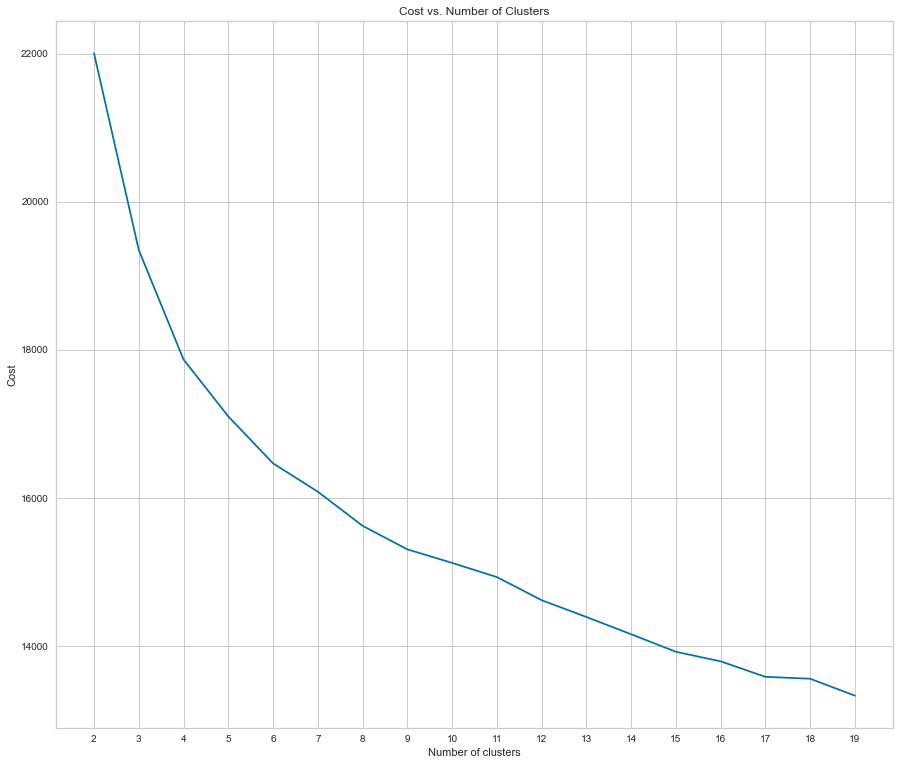

In [450]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(k_proto_range, cost_k_proto, label='Cost')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Cost')
ax.set_title('Cost vs. Number of Clusters')
ax.set_xticks(k_proto_range)
plt.show();

Using the kneedle algorithm:

In [451]:
kneedle = KneeLocator(k_proto_range, cost_k_proto, curve='convex', direction='decreasing')
print(f'Optimal number of clusters: {kneedle.knee}')

Optimal number of clusters: 6


In [453]:
kproto_model = KPrototypes(n_clusters=kneedle.knee, init='Huang', verbose=0, random_state=rs, n_jobs=-1) # Using euclidean for numerical columns and matching dissimilarity for categorical columns
kproto_model.fit(df_sampled_k_proto, categorical=cat_cols_indices)

KPrototypes(gamma=0.5189213564228508, init='Huang', n_clusters=6, n_jobs=-1,
            random_state=RandomState(MT19937) at 0x7FE9E1EDDC40)

To visualize the clustering results, we again compute the gower distance matrix and use MDS to create a two-dimensional representation of the 5000-dimensional matrix.

In [459]:
# Compute Gower distance matrix
gower_mat_kproto = gower_matrix(df_sampled_k_proto, cat_features=None)
gower_mat_kproto

mds_model_kproto = MDS(
    n_components=2,
    metric=True,
    n_init=4, # Number of times the algorithm will be run with different initial centroid seeds
    max_iter=300, # Maximum number of iterations of the SMACOF (Scaling by Majorizing a COmplicated Function) algorithm for a single run
    n_jobs=-1,
    random_state=rs,
    dissimilarity='precomputed', # Use precomputed distance matrix
    normalized_stress='auto'
)

mds_mappings_kproto = mds_model_kproto.fit_transform(gower_mat_kproto)
mds_mappings_kproto

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


array([[-0.40676274, -0.01616569],
       [-0.35939807, -0.33251655],
       [-0.4405138 ,  0.31216523],
       ...,
       [ 0.06306036, -0.24495477],
       [ 0.15867175,  0.3617674 ],
       [-0.29174394, -0.15503413]])

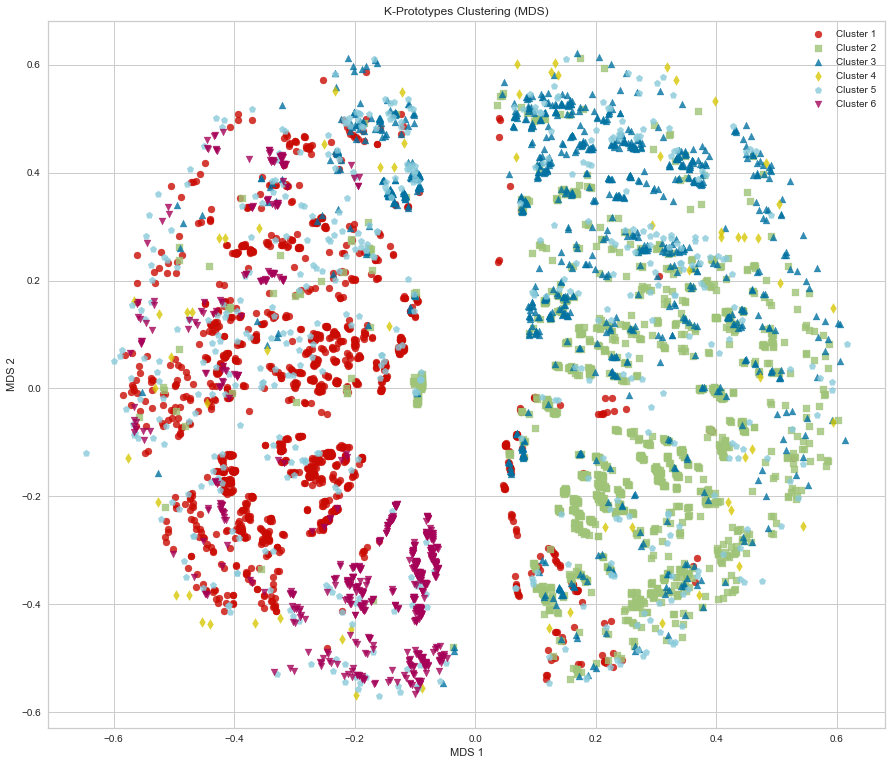

In [460]:
# Data for plotting
x_kproto = mds_mappings_kproto[:, 0]
y_kproto = mds_mappings_kproto[:, 1]
c_kproto = kproto_model.labels_

# Define a color map and markers for each cluster
colors = ['r', 'g', 'b', 'y', 'c', 'm']
markers = ['o', 's', '^', 'd', 'p', 'v']
alpha = [0.8] * len(colors)

# Create the scatter plot
fig, ax = plt.subplots(figsize=fig_size)
for index, c in np.ndenumerate(np.unique(c_kproto)):
    mask = c_kproto == c
    ax.scatter(x_kproto[mask], y_kproto[mask], c=colors[index[0]], marker=markers[index[0]], alpha=alpha[index[0]])
    
# Add axis labels and show the plot
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.title('K-Prototypes Clustering (MDS)')
plt.legend(['Cluster ' + str(i) for i in range(1, len(colors) + 1)])
plt.show();

Add the labels:

In [461]:
df_sampled_k_proto['k_prototypes_cluster'] = c_kproto
df_sampled_k_proto['k_prototypes_cluster'].head(5)

83970     0
162542    0
19781     0
142462    2
72218     2
Name: k_prototypes_cluster, dtype: uint16